# Import libraries

In [34]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm

import seaborn as sns

import json

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

from joblib import Parallel
from joblib import delayed
from tqdm_joblib import tqdm_joblib

from collections import defaultdict

from tqdm import tqdm

In [2]:
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)

In [3]:
path_to_save = './../results/03c_features_analysis'

# Loading data

In [4]:
path_to_ftir_data= './../data/processed_data/ftir_features_long_list.csv'
path_to_features_description = './../data/processed_data/features_description.json'
path_to_samples_description = './../data/parsed_data/samples_description.csv'

## FTIR-features (*long-list*)

In [5]:
features_df = pd.read_csv(path_to_ftir_data, sep=';', index_col=0)

print(features_df.shape)
features_df.head(3)

(75, 4777)


,$\overline{I}_{3800\text{–}2200}$,$\overline{I}_{3800\text{–}2400}$,$I_{3720}$,$\overline{I}_{3720 \pm 25}$,$\overline{I}_{3720 \pm 50}$,$I_{3533}$,$\overline{I}_{3533 \pm 25}$,$\overline{I}_{3533 \pm 50}$,$I_{3405}$,$\overline{I}_{3405 \pm 25}$,$\overline{I}_{3405 \pm 50}$,$I_{3302}$,$\overline{I}_{3302 \pm 25}$,$\overline{I}_{3302 \pm 50}$,$I_{3201}$,$\overline{I}_{3201 \pm 25}$,$\overline{I}_{3201 \pm 50}$,$I_{3132}$,$\overline{I}_{3132 \pm 25}$,$\overline{I}_{3132 \pm 50}$,$I_{3001}$,$\overline{I}_{3001 \pm 25}$,$\overline{I}_{3001 \pm 50}$,$I_{2926}$,$\overline{I}_{2926 \pm 25}$,...,"$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 3800\text{–}2400}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 2400\text{–}2200}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2400}}{\Sigma I_{p,\ 2400\text{–}2200}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2400}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2400}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2400}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2400}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 2400\text{–}2200}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\Sigma I_{p,\ 2400\text{–}2200}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\Sigma I_{p,\ 2400\text{–}2200}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 2400\text{–}2200}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 1800\text{–}1500}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 1800\text{–}1500}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 1500\text{–}1300}}{\Sigma I_{p,\ 1300\text{–}900}}$"
division_1_size_bulk,0.425422,0.462285,0.084601,0.076032,0.071260,0.506784,0.511390,0.524201,0.938564,0.935451,0.928330,1.000000,0.967122,0.963302,0.815223,0.819056,0.822279,0.720771,0.714901,0.710538,0.498252,0.499682,0.501630,0.422644,0.422996,...,0.030859,0.067391,0.189109,0.081443,1.068628,15.571275,0.621029,1.356218,3.805731,1.639009,14.571275,0.581146,1.269121,3.561324,1.533751,0.039883,0.087097,0.244407,0.105259,2.183824,6.128105,2.639183,2.806135,1.208515,0.430669
division_1_size_5,0.439080,0.480354,0.038211,0.036371,0.046173,0.652508,0.657052,0.667775,1.000000,0.985547,0.976453,0.942571,0.941360,0.940593,0.814723,0.815564,0.814640,0.704920,0.702329,0.701261,0.486172,0.487186,0.494274,0.448983,0.445307,...,0.030350,0.062274,0.187581,0.086505,1.057754,18.314756,0.685693,1.406955,4.238007,1.954410,17.314756,0.648254,1.330135,4.006609,1.847698,0.037439,0.076821,0.231399,0.106712,2.051873,6.180616,2.850268,3.012183,1.389106,0.461163
division_1_size_3,0.428649,0.463028,0.074497,0.065544,0.062297,0.598526,0.602768,0.611808,1.000000,0.959284,0.951557,0.937402,0.935431,0.933702,0.760651,0.763172,0.764610,0.637583,0.636283,0.638100,0.450708,0.455257,0.473817,0.547936,0.532374,...,0.032330,0.069703,0.220262,0.083028,1.080496,13.422929,0.612609,1.320767,4.173611,1.573251,12.422929,0.566970,1.222371,3.862680,1.456045,0.045639,0.098396,0.310931,0.117206,2.155971,6.812848,2.568116,3.159990,1.191164,0.376952


## Features description

In [6]:
with open(path_to_features_description, 'r', encoding='utf-8') as f:
    features_description = json.load(f)

## Samples description

In [7]:
samples_description = pd.read_csv(f'{path_to_samples_description}', sep=';', index_col=0)

print(samples_description.shape)
samples_description.head(3)

(75, 6)


,Row_ID,Division,Size,Fraction_hue,Fraction_grouped_hue,Class
division_1_size_bulk,1,1,bulk,$> 0$,$d > 5$,2
division_1_size_5,2,1,5,$< 5$,$2 < d \leq 5$,1
division_1_size_3,3,1,3,$< 3$,$2 < d \leq 5$,1


# Data wrangling

## Base parameters

In [8]:
hue = samples_description['Fraction_grouped_hue'].tolist()
target = samples_description['Class'].tolist()

In [9]:
type_color_dict = {
    '$0< d \leq 2$': '#2166AC',
    '$2 < d \leq 5$': '#67A9CF',
    '$d > 5$': '#B2182B'
}

In [11]:
groups = list(type_color_dict.keys())

In [12]:
sns.set_theme()

## Dictionaty for features mapping to type

In [36]:
feature_to_types = defaultdict(list)

for feature_type, features in features_description.items():
    for feature in features:
        feature_to_types[feature].append(feature_type)

# Modeling

## *One-factor* analysis

### Calculation process

In [13]:
def evaluate_single_feature(feature, features_df, target):
    X_train_of = features_df[[feature]]
    
    estimator = DecisionTreeClassifier(max_depth=3, random_state=42)
    estimator.fit(X_train_of, target)
    
    y_score = estimator.predict_proba(X_train_of)

    try:
        metric_ovr = roc_auc_score(y_true=target, y_score=y_score, multi_class='ovr')
        metric_ovo = roc_auc_score(y_true=target, y_score=y_score, multi_class='ovo')
    except ValueError:
        metric_ovr = None
        metric_ovo = None

    result_dict = {
        'Feature': feature,
        '$ROC-AUC_{ovr}$': metric_ovr,
        '$ROC-AUC_{ovo}$': metric_ovo
    }
    return result_dict

In [14]:
features_list = features_df.columns.tolist()

with tqdm_joblib(desc='Calculation progress', total=len(features_list)) as progress_bar:
    results = Parallel(
        n_jobs=-1,
        backend='loky'
    )(
        delayed(evaluate_single_feature)(feature, features_df, target)
        for feature in features_list
    )

Calculation progress:   0%|          | 0/4777 [00:00<?, ?it/s]

In [41]:
df_metrics = pd.DataFrame(results)

df_metrics = df_metrics.sort_values(by=['$ROC-AUC_{ovr}$', '$ROC-AUC_{ovo}$'], ascending=[False, False])

print(df_metrics.shape)
df_metrics.head(3)

(4777, 3)


,Feature,$ROC-AUC_{ovr}$,$ROC-AUC_{ovo}$
1922,$\frac{I_{3132}}{\overline{I}_{2926 \pm 50}}$,0.928608,0.932284
942,$\frac{I_{3533}}{I_{2926}}$,0.926815,0.930013
2558,"$\frac{\overline{I}_{2926 \pm 50}}{\Sigma I_{p,\ 3800\text{–}2200}}$",0.925326,0.928786


### Mapping features with their types

In [43]:
rows = []

for _, row in df_metrics.iterrows():
    feature = row['Feature']
    feature_types = feature_to_types.get(feature, [])

    for feature_type in feature_types:
        row_copy = row.copy()
        row_copy['Feature_Type'] = feature_type
        rows.append(row_copy)

df_metrics_expanded = pd.DataFrame(rows)

print(df_metrics_expanded.shape)
df_metrics_expanded.head(3)

(9554, 4)


,Feature,$ROC-AUC_{ovr}$,$ROC-AUC_{ovo}$,Feature_Type
1922,$\frac{I_{3132}}{\overline{I}_{2926 \pm 50}}$,0.928608,0.932284,engineered_features_intervals_3800_2200
1922,$\frac{I_{3132}}{\overline{I}_{2926 \pm 50}}$,0.928608,0.932284,engineered_features
942,$\frac{I_{3533}}{I_{2926}}$,0.926815,0.930013,engineered_features_peaks_3800_2200


### Visualization

In [50]:
feature_types = [
    'base_features_peaks_3800_2200',
    'base_features_intervals_3800_2200',
    'base_features_peaks_1900_800',
    'base_features_intervals_1900_800',
    'engineered_features_peaks_3800_2200',
    'engineered_features_intervals_3800_2200',
    'engineered_features_peaks_1900_800',
    'engineered_features_intervals_1900_800'
]

In [51]:
PLOT_STYLE = {
    'TITLE_FONT_SIZE': 14,
    'TITLE_FONTSTYLE': 'italic',
    'X_LABEL_FONT_SIZE': 12,
    'Y_LABEL_FONT_SIZE': 12,
    'X_TICK_LABEL_FONT_SIZE': 10,
    'Y_TICK_LABEL_FONT_SIZE': 10,
    'X_LABELPAD': 8,
    'Y_LABELPAD': 8,
    'X_NBINS': 6,
    'BAR_WIDTH': 0.7,
    'BAR_ALPHA': 0.85,
    'FIG_DPI': 300,
    'SUBPLOT_WIDTH': 5,
    'SUBPLOT_HEIGHT': 4,
    'TOP_N': 5,
    'COLOR_MAP': {
        'base': 'royalblue',
        'engineered': 'seagreen'
    }
}


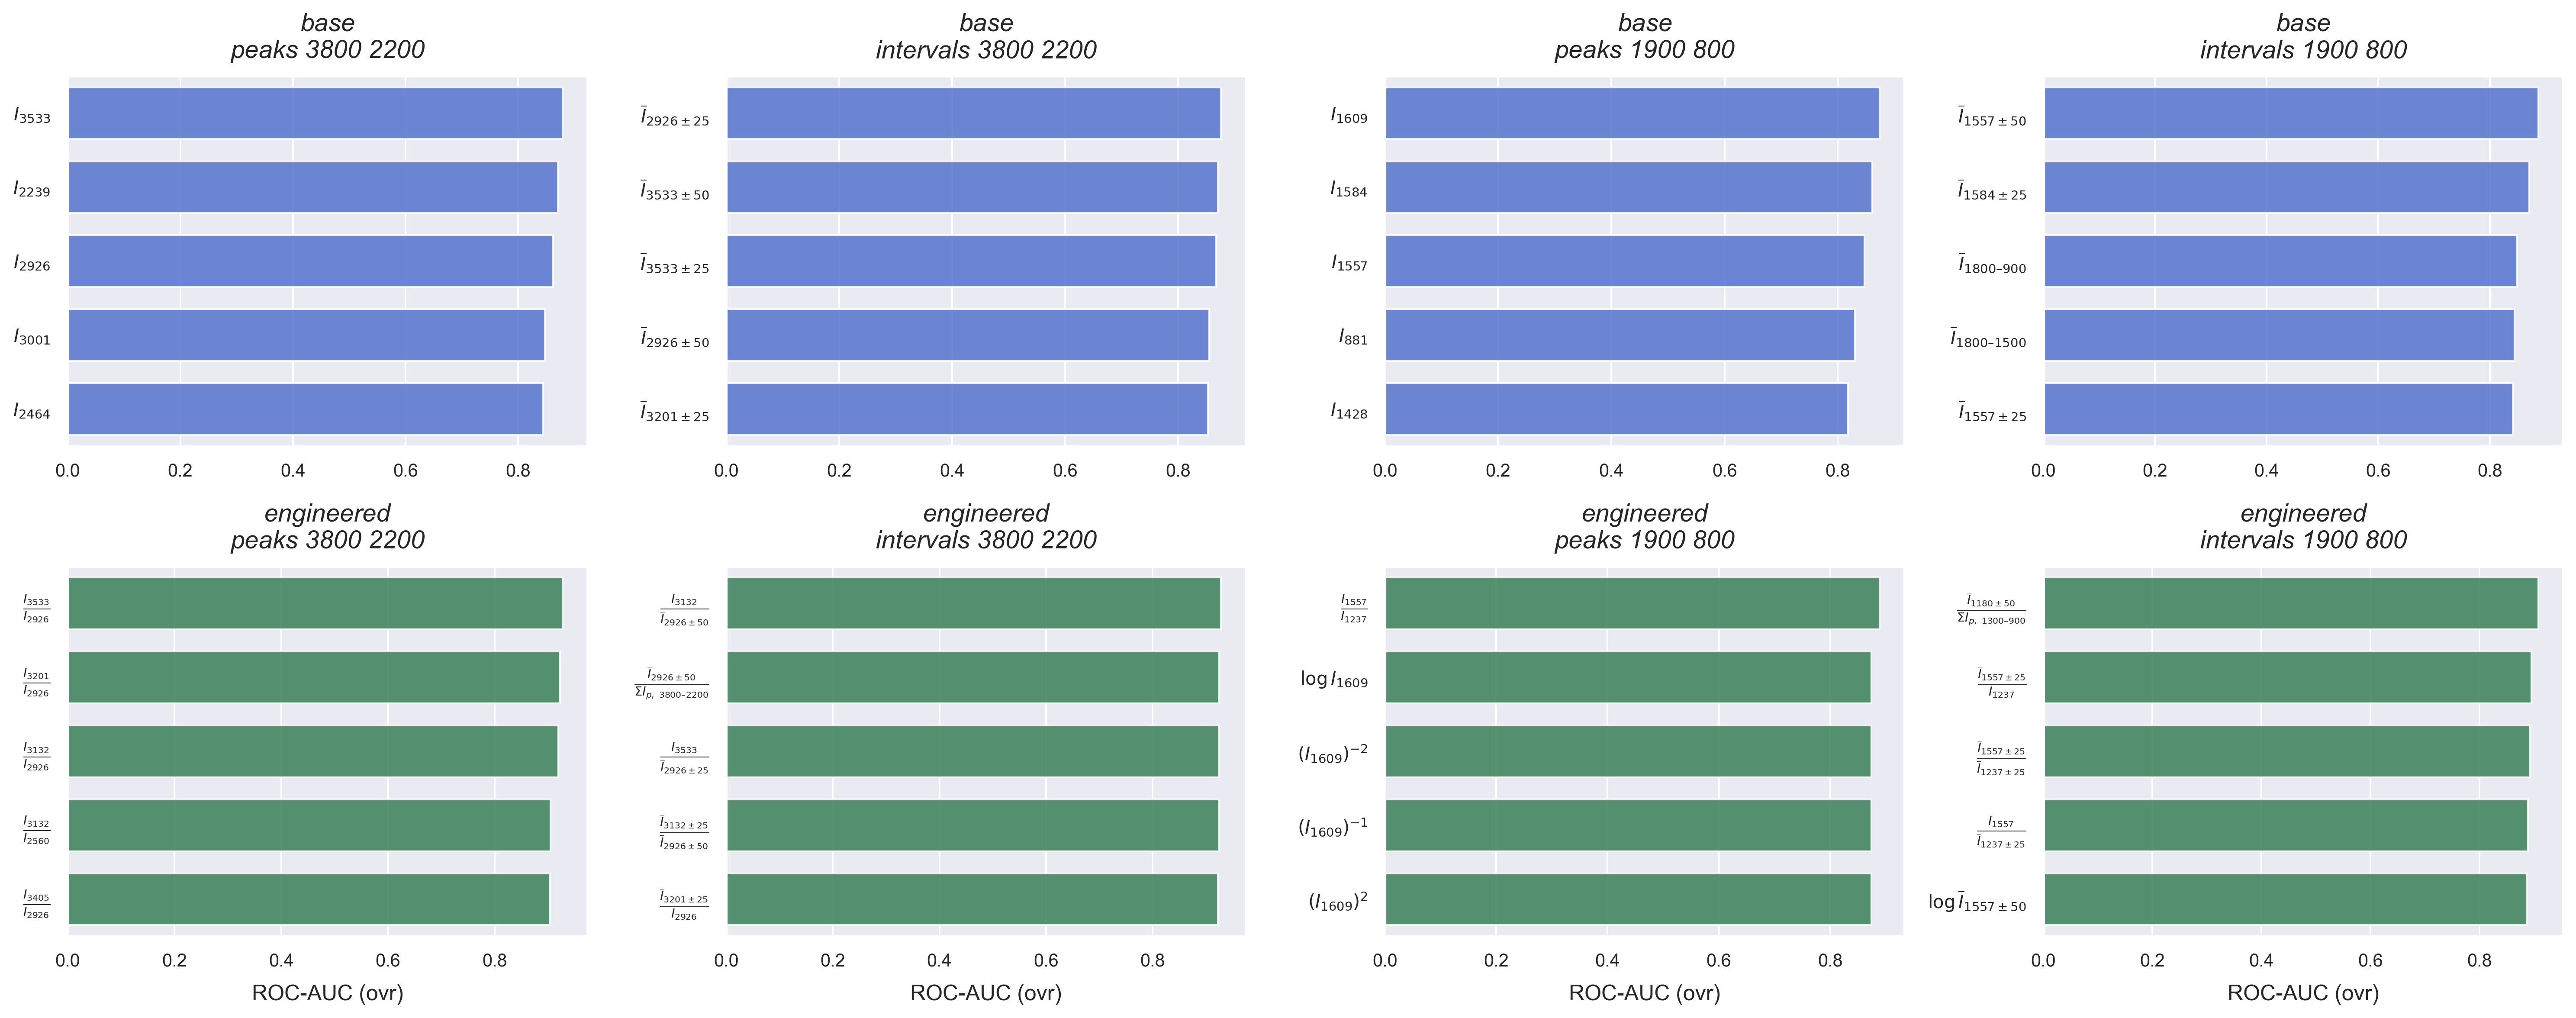

In [54]:
# feature_types = df_metrics_expanded['feature_type'].unique()
nrows, ncols = 2, 4

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * PLOT_STYLE['SUBPLOT_WIDTH'], nrows * PLOT_STYLE['SUBPLOT_HEIGHT']),
    dpi=PLOT_STYLE['FIG_DPI']
)
axes = axes.flat

for i, feature_type in enumerate(feature_types):
    subset = df_metrics_expanded[df_metrics_expanded['Feature_Type'] == feature_type]
    result_df = subset.sort_values(by='$ROC-AUC_{ovr}$', ascending=False).head(PLOT_STYLE['TOP_N'])

    kind = 'engineered' if 'engineered' in feature_type else 'base'
    color = PLOT_STYLE['COLOR_MAP'][kind]

    ax = axes[i]
    sns.barplot(
        data=result_df,
        x='$ROC-AUC_{ovr}$',
        y='Feature',
        ax=ax,
        color=color,
        width=PLOT_STYLE['BAR_WIDTH'],
        alpha=PLOT_STYLE['BAR_ALPHA']
    )

    title = feature_type.replace('_features_', '\n').replace('_', ' ')
    ax.set_title(
        title,
        fontsize=PLOT_STYLE['TITLE_FONT_SIZE'],
        fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'],
        pad=10
    )

    if i >= 4:
        ax.set_xlabel('ROC-AUC (ovr)', fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])
    else:
        ax.set_xlabel('')

    ax.set_ylabel('', fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])
    ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
    ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

# Удалим лишние оси
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
# plt.savefig(f'{path_to_save}/roc_auc_barplots.png', dpi=600)
plt.show()


In [46]:
aggregated_stats_df = (
    df_metrics_expanded
    .groupby('Feature_Type')
    [['$ROC-AUC_{ovr}$', '$ROC-AUC_{ovo}$']]
    .agg(['mean', 'std', 'min', 'max', 'count'])
    .round(4)
)
aggregated_stats_df

$ROC-AUC_{ovr}$                  \
                                                   mean     std     min   
Feature_Type                                                              
base_features                                    0.8158  0.0350  0.7389   
base_features_intervals_1900_800                 0.8005  0.0327  0.7397   
base_features_intervals_3800_2200                0.8318  0.0275  0.7389   
base_features_peaks_1900_800                     0.8016  0.0393  0.7428   
base_features_peaks_3800_2200                    0.8423  0.0186  0.8214   
engineered_features                              0.8209  0.0397  0.6380   
engineered_features_intervals_1900_800           0.7997  0.0396  0.6380   
engineered_features_intervals_3800_2200          0.8300  0.0359  0.6860   
engineered_features_peaks_1900_800               0.8039  0.0408  0.6715   
engineered_features_peaks_3800_2200              0.8335  0.0360  0.7121   

                                                      $ROC-AUC_{ovo}$          \
                                            max count            mean     std   
Feature_Type                                                                    
base_features                            0.8867    95          0.8191  0.0358   
base_features_intervals_1900_800         0.8867    38          0.8031  0.0330   
base_features_intervals_3800_2200        0.8761    30          0.8358  0.0288   
base_features_peaks_1900_800             0.8740    15          0.8041  0.0399   
base_features_peaks_3800_2200            0.8787    12          0.8464  0.0183   
engineered_features                      0.9286  4682          0.8243  0.0402   
engineered_features_intervals_1900_800   0.9077  1304          0.8022  0.0399   
engineered_features_intervals_3800_2200  0.9286  2919          0.8339  0.0363   
engineered_features_peaks_1900_800       0.8889   165          0.8065  0.0412   
engineered_features_peaks_3800_2200      0.9268   294          0.8373  0.0363   

                                                               
                                            min     max count  
Feature_Type                                                   
base_features                            0.7354  0.8886    95  
base_features_intervals_1900_800         0.7426  0.8886    38  
base_features_intervals_3800_2200        0.7354  0.8793    30  
base_features_peaks_1900_800             0.7449  0.8768    15  
base_features_peaks_3800_2200            0.8221  0.8837    12  
engineered_features                      0.6397  0.9323  4682  
engineered_features_intervals_1900_800   0.6397  0.9090  1304  
engineered_features_intervals_3800_2200  0.6852  0.9323  2919  
engineered_features_peaks_1900_800       0.6730  0.8931   165  
engineered_features_peaks_3800_2200      0.7153  0.9300   294